In [1]:
import numpy as np
from stl import mesh
import matplotlib.pyplot as plt
import vedo as vd

## Code to read an ".obj" file

In [2]:
# Read the .obj file
def read_obj(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    vertices = []
    faces = []
    for line in lines:
        if line.startswith("#"):
            continue
        values = line.split()
        if not values:
            continue
        if values[0] == "v":
            v = list(map(float, values[1:4]))
            vertices.append(v)
        elif values[0] == "f":
            face = []
            for v in values[1:]:
                w = v.split("/")
                face.append(int(w[0]))
            faces.append(face)

    vertices = np.array(vertices)
    faces = np.array(faces) - 1

    return vertices, faces

## Specify the file

In [3]:
V, T = read_obj("Ellipsoid.obj")

## Visualize the surface

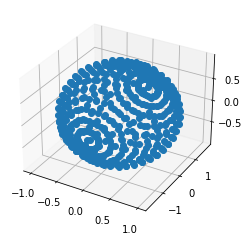

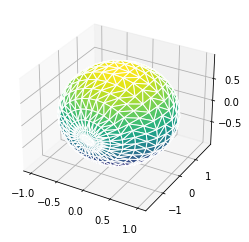

In [4]:
# %matplotlib widget
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(V[:,0],V[:,1],V[:,2], 'o')
plt.show()

ax = plt.axes(projection='3d')
ax.plot_trisurf(V[:, 0], V[:, 1], V[:, 2], triangles=T, cmap='viridis', edgecolor='White')
plt.show()

## How to relate the area coordinates of 2 neighboring triangles

![abc2ABC](abc2ABC.png)

$\qquad \vec{\mathbf{X}} = a \; \vec{\mathbf{X}}_a + b \; \vec{\mathbf{X}}_b + c \; \vec{\mathbf{X}}_c$ \
$\qquad \vec{\mathbf{X}} = A \; \vec{\mathbf{X}}_A + B \; \vec{\mathbf{X}}_B + C \; \vec{\mathbf{X}}_C$

$\vec{\mathbf{X}}_a = (0,0); \;\; \vec{\mathbf{X}}_b = (L_{ab},0); \;\; \vec{\mathbf{X}}_c = (D_{ab},H_c)$ \
$\vec{\mathbf{X}}_A = (0,0); \;\; \vec{\mathbf{X}}_B = (L_{AB},0); \;\; \vec{\mathbf{X}}_C = (D_{AB},-H_C)$

where $L_{ij} = \left| \vec{\mathbf{X}}_i - \vec{\mathbf{X}}_j \right|$ and from the figure,

$\qquad L_{ca}^2 = D_{ab}^2 + H_c^2$ \
$\qquad L_{bc}^2 = (L_{ab}-D_{ab})^2 + H_c^2$ 

$\Rightarrow D_{ab} = (L_{ab}^2 - L_{bc}^2 + L_{ca}^2) / (2 L_{ab}) \qquad$ and $\qquad H_c = \sqrt{L_{ca}^2 - D_{ab}^2}$.

From the first set of relations,

$\qquad a (0,0) + b (L_{ab},0) + c (D_{ab},H_c) = A (0,0) + B (L_{AB},0) + C (D_{AB},-H_C)$

and equating coefficients of each components, we get

$\qquad C = - (H_c/H_C) c$\
$\qquad B = b + ( c \; D_{ab} - C \; D_{AB}) / L_{AB}  = b + c \; ( D_{ab} + (Hc/H_C) \; D_{AB}) / L_{AB}$\
$\qquad A = a + ( c \; (L_{ab}-D_{ab}) - C \; (L_{AB}-D_{AB})) / L_{AB}  = a + c \; ( (L_{ab}-D_{ab}) + (Hc/H_C) \; (L_{AB}-D_{AB})) / L_{AB}$

Hence,

$\qquad \left( \begin{matrix} A \\ B \\ C \end{matrix} \right) = \left(
  \begin{matrix} 1 & 0 & ( \bar{D}_{ab} + (Hc/H_C) \; \bar{D}_{AB}) / L_{AB}  \\
                 0 & 1 & ( D_{ab} + (Hc/H_C) \; D_{AB}) / L_{AB}  \\
                 0 & 0 & - (H_c/H_C)
  \end{matrix} \right)
  \left( \begin{matrix} a \\ b \\ c \end{matrix} \right) $
  
  where, $\bar{D}_{ij} = (L_{ij} - D_{ij})$.


## Build the Triangle neighborhood and transformation data structure

In [5]:
TE2TE = np.zeros([len(T),3,2],dtype=int)
abc2ABC = np.zeros([len(T),3,3,3])

for Tabc in range(0,len(T)):
    for j in range(0,3):

        a, b, c = j, (j+1)%3, (j+2)%3

        Va = T[Tabc][a]
        Vb = T[Tabc][b]
        Vc = T[Tabc][c]

        Flag = 0

        for TABC in range(0,len(T)):
            if( Tabc != TABC ):
                for l in range(0,3):

                    A, B, C = l, (l+1)%3, (l+2)%3

                    VA = T[TABC][A]
                    VB = T[TABC][B]
                    VC = T[TABC][C]

                    if Va == VA and Vb == VB:
                        TE2TE[Tabc][a][0] = TABC+1
                        TE2TE[Tabc][a][1] = A+1

                        Flag = 1

                    if Va == VB and Vb == VA:
                        TE2TE[Tabc][a][0] =  TABC+1
                        TE2TE[Tabc][a][1] = -(A+1)

                        A, B = B, A
                        VA, VB = VB, VA

                        Flag = 1

                    if( Flag == 1 ):

                        Lab = np.sqrt( (V[Va][0]-V[Vb][0])**2 + (V[Va][1]-V[Vb][1])**2 + (V[Va][2]-V[Vb][2])**2 )
                        Lbc = np.sqrt( (V[Vb][0]-V[Vc][0])**2 + (V[Vb][1]-V[Vc][1])**2 + (V[Vb][2]-V[Vc][2])**2 )
                        Lca = np.sqrt( (V[Vc][0]-V[Va][0])**2 + (V[Vc][1]-V[Va][1])**2 + (V[Vc][2]-V[Va][2])**2 )

                        Dab = (Lab**2 - Lbc**2 + Lca**2)/(2*Lab)
                        Hc = np.sqrt(Lca**2 - Dab**2)

                        LAB = np.sqrt( (V[VA][0]-V[VB][0])**2 + (V[VA][1]-V[VB][1])**2 + (V[VA][2]-V[VB][2])**2 )
                        LBC = np.sqrt( (V[VB][0]-V[VC][0])**2 + (V[VB][1]-V[VC][1])**2 + (V[VB][2]-V[VC][2])**2 )
                        LCA = np.sqrt( (V[VC][0]-V[VA][0])**2 + (V[VC][1]-V[VA][1])**2 + (V[VC][2]-V[VA][2])**2 )

                        DAB = (LAB**2 - LBC**2 + LCA**2)/(2*LAB)
                        HC = np.sqrt(LCA**2 - DAB**2)

                        abc2ABC[Tabc][a][A][a] = 1
                        abc2ABC[Tabc][a][B][b] = 1
                        abc2ABC[Tabc][a][C][c] = - Hc/HC

                        abc2ABC[Tabc][a][B][c] = (Dab + Hc/HC * DAB)/LAB
                        abc2ABC[Tabc][a][A][c] = ((Lab-Dab) + Hc/HC * (LAB-DAB))/LAB
                        
                        break
                
                if( Flag == 1 ):
                    break


## Draw a geodesic starting from a random triangle and in the direction given by (da,db,dc)

In [8]:
T1 = int(len(T) * np.random.rand(1))

print(T1)

a, b, c = 0.1, 0.4, 0.5
da, db, dc = 0.3, -0.1, -0.2

dt = 0.1
NumIteration = 10000

Geodesic = []
TTrail = [T1]

for i in range(0,NumIteration):
    X1 = a * V[T[T1][0]] + b * V[T[T1][1]] + c * V[T[T1][2]]

    Geodesic.append(X1)

    a = a + da * dt
    b = b + db * dt
    c = c + dc * dt

    aa = -1

    if( a < 0 ):
        aa = 1
    elif( b < 0 ):
        aa = 2
    elif( c < 0 ):
        aa = 0

    if( aa != -1 ):

        T2 = TE2TE[T1][aa][0] - 1

        if( T2==-1 ):
            print("Error: T2==-1")
            print(len(Geodesic))
            break

        A = a * abc2ABC[T1][aa][0][0] + b * abc2ABC[T1][aa][0][1] + c * abc2ABC[T1][aa][0][2]
        B = a * abc2ABC[T1][aa][1][0] + b * abc2ABC[T1][aa][1][1] + c * abc2ABC[T1][aa][1][2]
        C = a * abc2ABC[T1][aa][2][0] + b * abc2ABC[T1][aa][2][1] + c * abc2ABC[T1][aa][2][2]

        dA = da * abc2ABC[T1][aa][0][0] + db * abc2ABC[T1][aa][0][1] + dc * abc2ABC[T1][aa][0][2]
        dB = da * abc2ABC[T1][aa][1][0] + db * abc2ABC[T1][aa][1][1] + dc * abc2ABC[T1][aa][1][2]
        dC = da * abc2ABC[T1][aa][2][0] + db * abc2ABC[T1][aa][2][1] + dc * abc2ABC[T1][aa][2][2]

        a, b, c = A, B, C
        da, db, dc = dA, dB, dC
        T1 = T2

        TTrail.append(T1)

Geodesic = np.array(Geodesic)

607


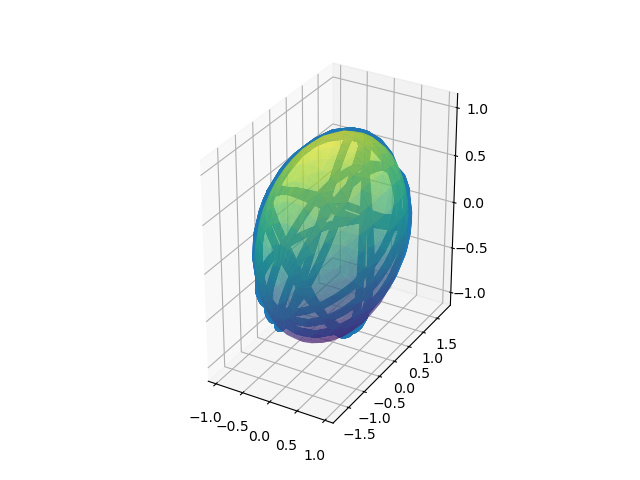

In [10]:
XScale = np.abs( np.max(V[:,0]) - np.min(V[:,0]) )
YScale = np.abs( np.max(V[:,1]) - np.min(V[:,1]) )
ZScale = np.abs( np.max(V[:,2]) - np.min(V[:,2]) )

XScale = XScale / np.max([XScale,YScale,ZScale])
YScale = YScale / np.max([XScale,YScale,ZScale])
ZScale = ZScale / np.max([XScale,YScale,ZScale])

%matplotlib widget
ax = plt.axes(projection='3d')
ax.set_box_aspect(aspect = (XScale,YScale,ZScale))
ax.scatter(Geodesic[:,0],Geodesic[:,1],Geodesic[:,2],'.')
# ax.scatter(Geodesic[0,0],Geodesic[0,1],Geodesic[0,2],'x')
ax.plot_trisurf(V[:, 0], V[:, 1], V[:, 2], triangles=T, cmap='viridis',alpha=0.5)
plt.show()